In [2]:
import numpy as np
import pandas as pd
import csv
import re

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

In [3]:
def preprocess(text):
    text = text.lower()
    text = ''.join(re.findall(r'[ а-я]', text))
    return text.split()

In [4]:
tweets = []
    
try:
    reader = csv.reader(open('twitter.csv', 'r'), delimiter=';')
    for line in reader:
        line = preprocess(line[3])
        if len(line) > 10:
            tweets.append(line)
except: # some bug with encoding in the end of file
    pass

tweets = tweets[:8500]

In [5]:
tolstoy = []

with open('tolst.txt', 'r', encoding="windows-1251") as file:
    for line in file:
        line = preprocess(line)
        if len(line) > 10:
            tolstoy.append(line)

In [6]:
import urllib.request
from bs4 import BeautifulSoup

def get_page(url):
    page = urllib.request.urlopen(url).read().decode('utf-8')
    soup = BeautifulSoup(page, 'html.parser')
    return soup

def parse_2ch():
    posts = get_page('https://2ch.hk/b/').select('.post_type_oppost a')
    
    links = set()
    for post in posts:
        idx = post.get('id')
        if isinstance(idx, str):
            links.add(idx)
            
    messages = []
    for idx in tqdm(links):
        print(idx)
        raw_messages = get_page(f'https://2ch.hk/b/res/{idx}.html').select('.post__message')
        for message in raw_messages:
            message = preprocess(message.text)
            if len(message) > 10:
                messages.append(message)
    
    return messages

dwach = parse_2ch()

  0%|          | 0/22 [00:00<?, ?it/s]

205644922


  5%|▍         | 1/22 [00:00<00:15,  1.35it/s]

205659712


 14%|█▎        | 3/22 [00:01<00:08,  2.12it/s]

205658629
205654795


 23%|██▎       | 5/22 [00:01<00:05,  3.14it/s]

205662153
205661302


 32%|███▏      | 7/22 [00:01<00:03,  4.14it/s]

205661473
205650194


 41%|████      | 9/22 [00:03<00:06,  2.10it/s]

205661830
205662338


 50%|█████     | 11/22 [00:03<00:03,  3.32it/s]

205659311
205662011


 55%|█████▍    | 12/22 [00:04<00:02,  3.60it/s]

205655291


 59%|█████▉    | 13/22 [00:04<00:02,  3.77it/s]

205641956


 64%|██████▎   | 14/22 [00:05<00:04,  1.63it/s]

205657977


 68%|██████▊   | 15/22 [00:06<00:03,  1.78it/s]

205661558


 73%|███████▎  | 16/22 [00:06<00:02,  2.05it/s]

205650236


 77%|███████▋  | 17/22 [00:06<00:02,  2.14it/s]

205594858


 82%|████████▏ | 18/22 [00:09<00:04,  1.02s/it]

205660282


 86%|████████▋ | 19/22 [00:09<00:02,  1.18it/s]

205654018


 91%|█████████ | 20/22 [00:10<00:01,  1.08it/s]

205660512


 95%|█████████▌| 21/22 [00:11<00:00,  1.30it/s]

205659988


100%|██████████| 22/22 [00:11<00:00,  1.88it/s]


In [7]:
class Vocab:
    def __init__(self, corpora, tokenizer, max_len=20, vocab_size=5000):
        self.tokenizer = tokenizer
        self.max_len = max_len
        
        counts = {}
        
        for sentence in corpora:
            for token in sentence:
                counts[token] = counts.get(token, 0) + 1
        
        l = sorted(counts.items(), key=lambda x: -x[1])[:vocab_size-2]
        
        print('least used token:', l[-1])
        print('vocab size:', len(l), '(+2)')
        
        self.t2i = {"<pad>" : 0, "<unk>" : 1}
        self.i2t = {0 : "<pad>", 1 : "<unk>"}
              
        for token, _ in l:
            self.i2t[len(self.i2t)] = token
            self.t2i[token] = len(self.t2i)
    
    def tokenize(self, sentence, pad=True):
        if pad:
            sentence = sentence[:self.max_len]
            while len(sentence) < self.max_len:
                sentence.append('<pad>')
        
        indices = []
        for token in sentence:
            if token in self.t2i:
                indices.append(self.t2i[token])
            else:
                indices.append(1)
        
        return indices

In [8]:
# me: mom can we have oversampling?
# mom: but we have oversampling at home
# oversampling at home:
dataset_a = tweets
dataset_b = tolstoy
dataset_c = dwach+dwach+dwach+dwach+dwach+dwach+dwach+dwach 

print(len(dataset_a))
print(len(dataset_b))
print(len(dataset_c))

vocab = Vocab(dataset_a + dataset_b + dataset_c, preprocess)

8500
8620
8808
least used token: ('военном', 18)
vocab size: 4998 (+2)


In [9]:
class StyleDataset(Dataset):
    def __init__(self, corpora, vocab):
        self.vocab = vocab
        self.samples = []
        self.labels = []
        
        for i, dataset in enumerate(corpora):
            self.samples += dataset
            self.labels += [i] * len(dataset)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        X = self.vocab.tokenize(self.samples[idx])
        y = [self.labels[idx]] * len(X)
        return torch.LongTensor(X), torch.LongTensor(y)

In [10]:
dataset = StyleDataset([dataset_a, dataset_b, dataset_c], vocab)

# todo: this should be done before oversampling
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-512, 512])

train = DataLoader(train_dataset, batch_size=64, shuffle=True)
test = DataLoader(test_dataset, batch_size=64)

dataset[5]

(tensor([  20,   67,   46,    1,   35,  424, 2506,    4,   82,    4,    1,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [11]:
def fetch_embeddings(embeddings, vocab, embedding_dim=300):
    weights = torch.randn(len(vocab.t2i), embedding_dim) / 10
    
    print('reading file', embeddings)
    print('this may take a while...')
    
    with open(embeddings) as file:
        for line in file:
            data = line.split()
            if len(data) == embedding_dim + 1:
                token = data[0]
                vector = torch.Tensor([float(x) for x in data[1:]])
                if token in vocab.t2i:
                    weights[vocab.t2i[token]] = vector
    
    return weights


class StyleClassifier(nn.Module):
    def __init__(
        self,
        embeddings,
        embedding_dim=300,
        num_classes=3,
        hidden_dim=50,
        num_layers=1,
        rnn_dropout=0,
        bidirectional=False):
        
        super().__init__()
        
        self.embed = nn.Embedding.from_pretrained(embeddings)
        
        self.rnn = nn.GRU(
            embedding_dim,
            hidden_dim, 
            num_layers=num_layers, 
            bidirectional=bidirectional, 
            dropout=rnn_dropout,
            batch_first=True
        )
        
        self.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes),
            nn.LogSoftmax(dim=2)
        )
        
    def forward(self, X):
        X = self.embed(X)
        X, _ = self.rnn(X)
        X = self.head(X)
        return X

In [12]:
!touch empty.vec

In [13]:
embeddings = fetch_embeddings('wiki.ru.vec', vocab, embedding_dim=300)
model = StyleClassifier(embeddings)

reading file wiki.ru.vec
this may take a while...


In [14]:
test_batch = dataset[0][0].view(1, -1)
model(test_batch).exp()

tensor([[[0.2982, 0.3916, 0.3102],
         [0.3151, 0.3480, 0.3369],
         [0.3565, 0.3384, 0.3051],
         [0.3740, 0.3463, 0.2797],
         [0.3966, 0.3546, 0.2488],
         [0.3538, 0.3670, 0.2791],
         [0.3112, 0.4614, 0.2274],
         [0.2849, 0.3408, 0.3742],
         [0.3399, 0.3383, 0.3219],
         [0.3240, 0.4087, 0.2674],
         [0.3543, 0.3677, 0.2781],
         [0.2293, 0.3939, 0.3768],
         [0.2989, 0.3849, 0.3162],
         [0.3618, 0.3207, 0.3175],
         [0.3757, 0.3893, 0.2350],
         [0.3321, 0.3326, 0.3353],
         [0.3217, 0.3693, 0.3090],
         [0.3131, 0.3598, 0.3271],
         [0.3313, 0.3314, 0.3372],
         [0.3219, 0.3611, 0.3170]]], grad_fn=<ExpBackward>)

In [15]:
lr = 5e-2
num_epochs = 10
device = torch.device('cpu')

#model = StyleClassifier(len(vocab.i2t), 'fasttext.vec')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [16]:
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    
    for X, y in tqdm(train):
        X.to(device)
        y.to(device)
        
        optimizer.zero_grad()
        
        preds = model(X)
        
        loss = criterion(preds.view(-1, 3), y.view(-1))
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    test_loss = 0
    for X, y in tqdm(test):
        X.to(device)
        y.to(device)
        
        preds = model(X)
        loss = criterion(preds.view(-1, 3), y.view(-1))
        
        test_loss += loss.item()
    
    test_losses.append(test_loss)
    print('test loss:', test_loss)

  0%|          | 1/398 [00:00<00:55,  7.15it/s]

test loss: 5.104762494564056


  1%|          | 2/398 [00:00<00:22, 17.58it/s]

test loss: 5.192559242248535


  1%|          | 2/398 [00:00<00:21, 18.73it/s]

test loss: 4.879211068153381


  1%|          | 3/398 [00:00<00:16, 23.57it/s]

test loss: 6.129417598247528


  1%|          | 2/398 [00:00<00:23, 16.66it/s]

test loss: 4.971712946891785


  1%|          | 2/398 [00:00<00:23, 16.57it/s]

test loss: 4.634714305400848


  1%|          | 2/398 [00:00<00:20, 19.02it/s]

test loss: 5.279074490070343


  1%|          | 2/398 [00:00<00:25, 15.78it/s]

test loss: 4.957925915718079


  1%|          | 3/398 [00:00<00:18, 20.92it/s]

test loss: 4.814432680606842


100%|██████████| 8/8 [00:00<00:00, 50.21it/s]

test loss: 5.040948569774628


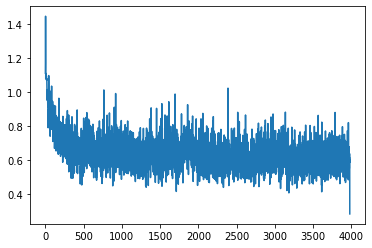

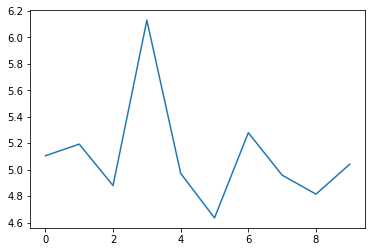

In [17]:
plt.plot(train_losses)
plt.show()

plt.plot(test_losses)
plt.show()

In [18]:
from IPython.core.display import display, HTML

def print_colored(sequence, intensities, delimeter=' '):
    html = delimeter.join([
        # https://en.wikipedia.org/wiki/Subtractive_color
        f'<span style="background: rgb({255*(1-x[1]-x[2])}, {255*(1-x[0]-x[2])}, {255*(1-x[0]-x[1])})">{c}</span>'
        for c, x in zip(sequence, intensities) 
    ])
    display(HTML(html))

In [19]:
samples = [
    'Сап б, есть одна тян. Двачую анон',
    'князь болконский с удивлением увидел',
    'засмеялся проиграл тред не нашел создал',
    'хахаха ну ты даешь',
    'омлирьтрьирттри'
    'Сап двач, есть однаапррвавапвпв хэштег тян, она как будто со вниманием слушала рассказ князя Василья',
    ' '.join(dataset_a[111]), # Твиттер, должен быть красным
    ' '.join(dataset_b[111]), # Война и Мир, должна быть зелёнойхз
    ' '.join(dataset_c[333]), # Двач, должен быть синим
    ' '.join(dataset_a[5] + dataset_b[5] + dataset_c[5])
]

model = model.cpu()

t = 1 # температура, для лучшей визуализации

for sample in samples:
    sentence = preprocess(sample)
    X = torch.LongTensor(vocab.tokenize(sample, pad=False)).view(-1, 1)
    scores = model(X).view(-1, 3).mul(t).softmax(dim=1)
    maxes, _ = torch.max(scores, dim=1)
    scores -= ((1-maxes)/2).view(-1, 1) # так будет ровно один "полный" цвет
    #print(scores)
    print_colored(sentence, scores)